<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Millennium Management: Data Assignment</h1><br><h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">Shreya Vontela , Masters in Financial Engineering,  UC Berkeley. </h2><br>

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Introduction</h2><br>

- In this assignment we are going to look at the a variable, **Signal**, which is the predicted ETF price of the 4sight model. 
- First, we are going to check the **quality of the Signal** and do the required adjustments. 
- Then we are going to create a benchmark Signal and analyse the **performance of the 4sight Signal wrt to the benchmark Signal** on a simple trading strategy. 

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Assumptions </h2><br>

1. The signal value on day T is derived from the stock price data available till day T-1. 
2. I am considering that the Signal is trying to predict the **Adjusted Close price** of the ETF. 
3. I am assuming that we are dealing with a daily data and **we need the prediction to be right on a daily basis**. This would depend on usage of the predicted signal. In some cases we want to trade daily so we would need the Signal to be accurate on a daily basis. Sometimes we need the accuracy on a weekly or monthly basis. So the analysis would depend on the usage. As the usage is not mentioned here, I am taking the daily data



In [1]:
#Imports and functions 
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import yfinance as yf
import datetime
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

#Function to plot a graph 
def plot_graph(df, columns, title, x_axis = "Date", y_axis = "Price",loc ='lower center'):
    plt.figure(figsize=(12,7))
    for column in columns:
        plt.plot(df[column], label = column)
    
    plt.legend(loc=loc,fontsize = 'large')
    plt.xlabel(x_axis, fontsize = 12 )
    plt.ylabel(y_axis, fontsize = 12)
    plt.title (title,fontsize = 15)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.grid(alpha =.6, linestyle ='--') 
    
    plt.gcf().autofmt_xdate()
    plt.show()

#Function to test stationarity of series using ADF test. 
def test_stationarity(timeseries, plot = True ):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    if plot == True : 
        #Plot rolling statistics:
        plt.figure(figsize=(12,7))
        plt.plot(timeseries, color='c',label='Spread')

        plt.legend(loc='best',fontsize = 'large')
        plt.xlabel("Date", fontsize = 12 )
        plt.title ("Stationarity of Spread between forecasted signal and adjusted close price",fontsize = 15)
        plt.xticks(fontsize = 10)
        plt.yticks(fontsize = 10)
        plt.grid(alpha =.6, linestyle ='--') 

        plt.gcf().autofmt_xdate()
        plt.show(block = False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
#Function to calculate max drawdown 
def calculate_max_drawdown(df, column , title, num_dashes):
    wealth_index = 1000 * (1+df_clean[column] ).cumprod()
    prev_peaks = wealth_index.cummax()
    foursight_DD = (wealth_index - prev_peaks)/prev_peaks
    date = foursight_DD.idxmin().strftime("%D")
    print(f"\033[1m\033[94m{title}\n{num_dashes * '-'}")
    print(f"\033[30m{round(min(foursight_DD.dropna()), 3), date }\n")
    
#Function to calcualte cumulative returns on a simple trading strategy
def cum_returns(df_clean,col,ind_col, cum_col, return_col ):
    #Predicting daily BUY and SELL signals based on daily returns
    df_clean[ind_col] = np.where(df_clean[col] > 0, "BUY", "SELL")
    
    #Implementing the BUY and SELL strategy 
    df_clean[cum_col] = df_clean["actual_returns"] * np.where(df_clean[ind_col] == "BUY", 1 , -1)
    
    #Calculating cumulative returns over time.
    df_clean[return_col] = (1 + df_clean[cum_col]).cumprod() - 1
    return df_clean

<h2 style="font-family: Georgia; font-size:2.5em;color:purple; font-style:bold">
1. Stratgies to check the Quality of Data</h2><br>

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
1.1 Check for missing values and data types: </h2><br>


- Below analysis shows that the data **does not have any missing values or object/mixed data types**

In [2]:
# Reading the dataset
df = pd.read_excel("Sample Dataset.xlsx")
df.index = df.Date


In [3]:
# Check for data types and missing values
print(f"\033[1m\033[94mData types:\n{11 * '-'}")
print(f"\033[30m{df.dtypes}\n")
print(f"\033[1m\033[94mSum of null values in each feature:\n{35 * '-'}")
print(f"\033[30m{df.isnull().sum()}")
df.head()

Data types:
-----------
Date         datetime64[ns]
Signal              float64
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
dtype: object

Sum of null values in each feature:
-----------------------------------
Date         0
Signal       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64


,Date,Signal,Open,High,Low,Close,Adj Close
Date,,,,,,,
2015-11-19,2015-11-19,13.768540,116.440002,116.650002,115.739998,116.059998,108.281601
2015-11-20,2015-11-20,13.608819,116.480003,117.360001,116.379997,116.809998,108.981323
2015-11-23,2015-11-23,12.990589,116.709999,117.889999,116.680000,117.389999,109.522453
2015-11-24,2015-11-24,12.667435,116.879997,118.419998,116.559998,118.250000,110.324837
2015-11-25,2015-11-25,13.019910,118.300003,119.320000,118.110001,119.169998,111.183159


<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
1.2 Examining the descriptive statistics </h2><br>


- The Signal data and Adjusted Close Price are on **different scales** (Signal has a mean of 16.7 but the Adj Close Price has a mean of 136.3)
- The Signal data has a min value of 0 and the adjusted close price has a negative min value.This means that there are some anamolies in the prediction 

In [4]:
df.describe()

,Signal,Open,High,Low,Close,Adj Close
count,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000
mean,16.766190,141.847360,142.691801,140.907746,141.840973,136.341060
std,3.095783,18.475574,18.470255,18.404504,18.497010,21.427837
min,0.000000,94.080002,95.400002,93.639999,94.790001,-152.277847
25%,14.691150,132.132496,132.912495,130.542503,131.824993,125.290491
50%,17.298240,146.769997,147.959999,145.634995,146.885002,142.667732
75%,19.030890,155.367496,156.287495,154.422500,155.289993,151.798325
max,35.434147,172.789993,173.389999,171.949997,196.279999,168.842270


<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
1.3 Examining the Outliers </h2><br>


From the below analysis we see that the adjusted close price has one big outlier. The second graph shows that the Signal data also has many outliers. Presence of such outliers is an indication of **structural breaks** in the data. 


### <span style="color:#2462C0"> Why Consider Adjusted Close Price ? 
- In general the close price of a stock is only effected by the supply and demand of the market participants. But the adjusted closing price **factors in corporate actions, such as stock splits, dividends, and rights offerings.** This gives a better picture of the stock’s performance and hence Adjusted close price is the common metric used in modelling. 
- As we are currently dealing with an ETF, the adjusted close price is not supposed to deviate from the Close price as the ETF is a mix of many assets.  

### <span style="color:#2462C0"> Is the deviation expected ? 

- This deviation is around **October of 2018, which is not a very volatile period.** So this deviation is an outlier. Even it it was a volatile period, we cannot have a negative adjusted price.  
- Now we need to remove the outlier to get the new adjusted price. 

### <span style="color:#2462C0"> How do you know if it is a volatile period ? 

- We can look at the **VIX volatility** during that time to get an estimate of the market volatility. The VIX is a benchmark index designed specifically to track S&P 500 volatility.

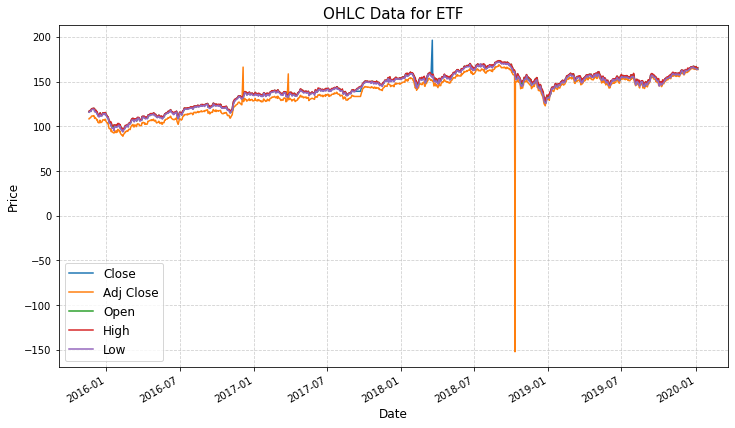

In [5]:
plot_graph(df,["Close","Adj Close", 
            "Open","High","Low"], 
           "OHLC Data for ETF", 
           loc = "lower left")

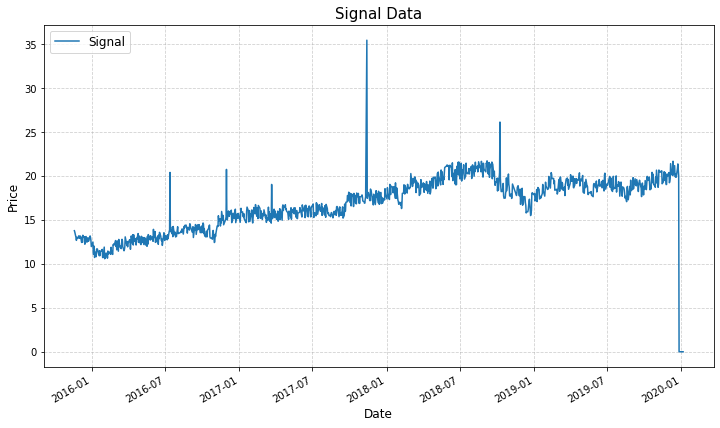

In [6]:
plot_graph(df,["Signal"], "Signal Data", loc = "upper left")

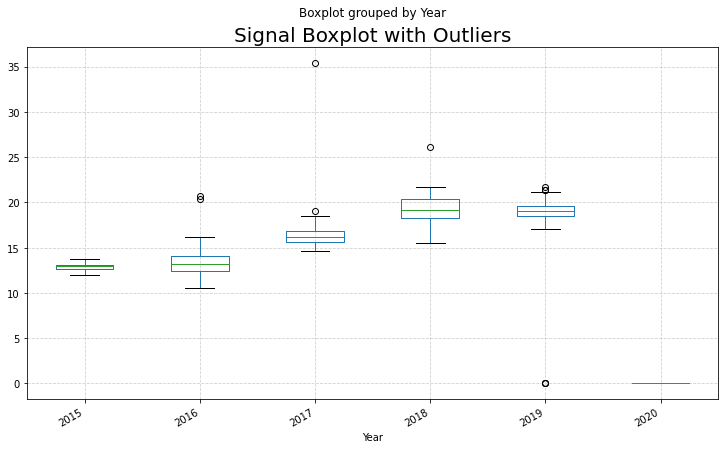

In [7]:
df["Year"] = df.Date.dt.to_period('Y')
df.boxplot(figsize=(12,7),by='Year',column='Signal')
plt.title ("Signal Boxplot with Outliers",fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.grid(alpha =.6, linestyle ='--') 
    
plt.gcf().autofmt_xdate()
plt.show()

### <span style="color:#2462C0"> Why Remove the outliers ? Why not treat them as missing values and Interpolate ? 
- Here I plan on removing the outlier and not interpolate with the existing data. This is because on analysis I found that the **ETF price series is a non-stationary series.** Interpolating on such a data might introduce more serial correlation
- Also any kind of mean/median or MICE imputation would not add much value to the prediction.
- So, I excluded the outlier data points as they did not cause much data loss. 

### <span style="color:#2462C0"> Methodology to find and remove outliers: 
There are many ways to find and remove the outliers. 
1. **Standard Deviation Method** : We can consider the standard deviation of the entire data and remove the data points that are more than 3 standard deviations away from mean. But this method can cause high **data leakage**. 
    

2. **Interquartile Range(IQR) Method** : In this method we sort the entire data and divide them into quartiles. IQR is the difference between the third quartile and the first quartile (IQR = Q3 -Q1). Outliers in this case are defined as the observations that are below (Q1 − 1.5x IQR) or above (Q3 + 1.5x IQR). This method is also prone to **data leakage**. 
    


3. **Rolling Standard Deviation Method** : This method solves the data leakage issue created by the Standard deviation method. Here we take a rolling mean and standard deviation of the time series and detect outliers as the points that are above 3 standard deviations. Below we take **3 SD for the Signal Data and 4 SD for the Price data** so that we don’t remove any actual adjustments in price.


In [8]:
# Identifying and removing outliers through rolling standard deviation method 

rolling_func = df["Signal"].rolling(window=(90))
upper_limit = rolling_func.mean() + 3* rolling_func.std()
lower_limit = rolling_func.mean() - 3* rolling_func.std()
signal_outliers = df[(df["Signal"] >= upper_limit) | (df["Signal"] <= lower_limit)]
df_new = df.drop(index=list(signal_outliers.index))
signal_outliers

,Date,Signal,Open,High,Low,Close,Adj Close,Year
Date,,,,,,,,
2016-07-13,2016-07-13,20.395083,120.330002,120.389999,118.949997,119.250000,112.691780,2016
2016-11-18,2016-11-18,15.955373,130.690002,131.089996,130.300003,130.990005,124.128242,2016
2016-11-30,2016-11-30,20.738650,132.919998,133.089996,131.500000,131.610001,124.715752,2016
2017-03-22,2017-03-22,19.029316,133.710007,134.309998,132.779999,134.000000,127.504295,2017
2017-09-26,2017-09-26,17.766227,144.289993,145.149994,144.179993,144.610001,138.927872,2017
2017-09-29,2017-09-29,18.139211,147.919998,148.429993,147.740005,148.179993,142.357590,2017
2017-11-13,2017-11-13,35.434147,145.929993,146.820007,145.500000,146.610001,140.849274,2017
2018-10-09,2018-10-09,26.124873,161.619995,162.740005,160.979996,161.190002,156.781219,2018
2019-12-27,2019-12-27,0.000000,167.119995,167.119995,165.429993,165.860001,164.039063,2019


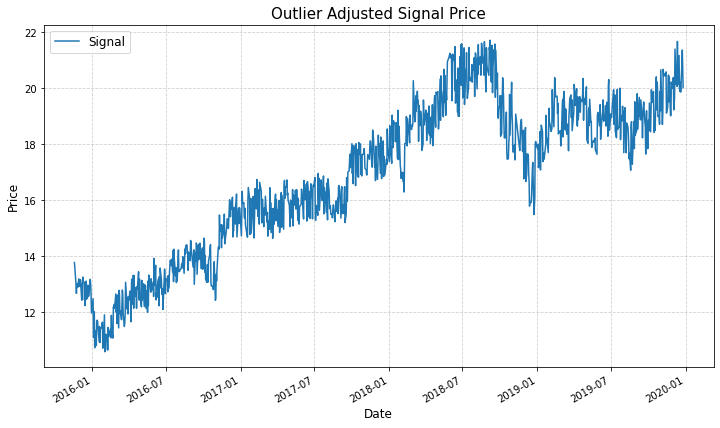

In [9]:
plot_graph(df_new,["Signal"], "Outlier Adjusted Signal Price", loc = "upper left")

In [10]:
#Identifying and removing outliers through rolling standard deviation method 

rolling_func = df_new["Adj Close"].rolling(window=(90))
upper_limit = rolling_func.mean() + 3.5* rolling_func.std()
lower_limit = rolling_func.mean() - 3.5* rolling_func.std()

price_outliers = df_new[(df_new["Adj Close"] >= upper_limit) | 
                         (df_new["Adj Close"] <= lower_limit)]
df_clean = df_new.drop(index=list(price_outliers.index))
price_outliers

,Date,Signal,Open,High,Low,Close,Adj Close,Year
Date,,,,,,,,
2016-12-05,2016-12-05,16.011011,131.970001,133.330002,131.889999,133.149994,166.175079,2016
2017-03-27,2017-03-27,16.032241,132.759995,135.070007,132.399994,134.740005,158.577637,2017
2017-09-27,2017-09-27,17.638584,145.630005,147.860001,145.160004,147.440002,141.646667,2017
2017-10-02,2017-10-02,18.015610,148.309998,150.000000,148.080002,150.000000,144.106079,2017
2017-10-03,2017-10-03,16.952524,150.110001,150.330002,149.330002,150.330002,144.423126,2017
2018-10-10,2018-10-10,19.719477,160.820007,160.990005,156.360001,156.559998,-152.277847,2018


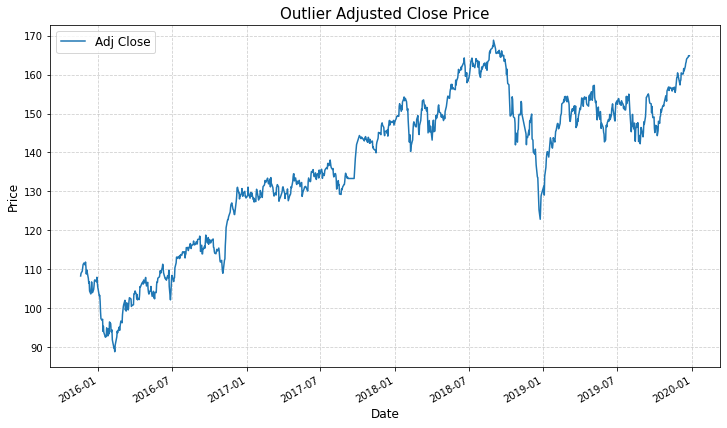

In [11]:
plot_graph(df_clean,["Adj Close"], "Outlier Adjusted Close Price", loc = "upper left")

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
1.3.1 Analysing the reason for outlier existence</h2><br>

- From the below graph we can see that the price outliers occurred at a lag to the signal outliers in most situations **(2016-Dec, 2017-March and 2017-Sept)**. In all of these cases, the outliers are above the mean for Signal and Price data. So, we are not sure if these outliers are actual market fluxuations or model errors. Having said that, if we closely look at the dates of these outliers, we can see that there has not been any sudden market events that occurred during this time. To get a better estimate of the market during this period we can further compare the **VIX prices** for these dates. So there is no reason for such high market volatility during this time.


- But the biggest outlier in price data is the one which occurred in **2018-Oct**. This is a **true anomaly because of its high magnitude and untimely occurrence**. This outlier definitely has to be removed form the dataset    

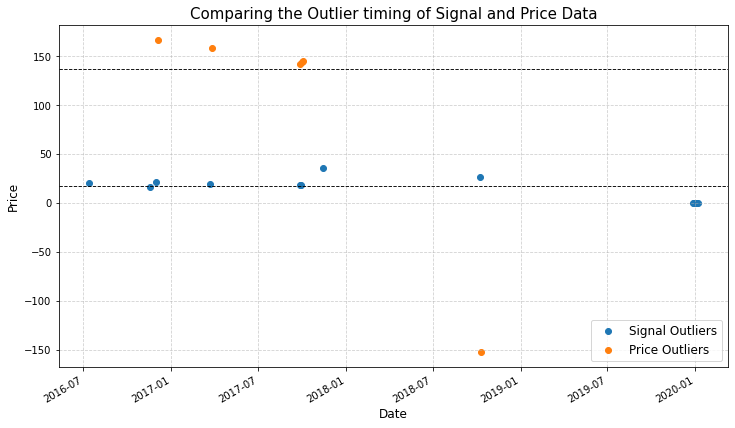

In [12]:
plt.figure(figsize=(12,7))
plt.scatter(signal_outliers.Date,signal_outliers["Signal"],label = "Signal Outliers")
plt.scatter(price_outliers.Date,price_outliers["Adj Close"], label = "Price Outliers")
plt.axhline(df_clean["Signal"].mean(), color='k', linestyle='dashed', linewidth=0.9) 
plt.axhline(df_clean["Adj Close"].mean(), color='k', linestyle='dashed', linewidth=0.9) 


plt.legend(fontsize = 'large', loc = "lower right")
plt.xlabel("Date", fontsize = 12 )
plt.ylabel("Price", fontsize = 12)
plt.title ("Comparing the Outlier timing of Signal and Price Data",fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.grid(alpha =.6, linestyle ='--') 

plt.gcf().autofmt_xdate()
plt.show()

<h2 style="font-family: Georgia; font-size:2.5em;color:purple; font-style:bold">
2. Signal's Forecasting Effectiveness</h2><br>

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
2.1 Correlation Analysis: </h2><br>

- Here we see that the signal and adjusted close price are **highly correlated.** (0.964)

In [13]:
df_clean.corr()

,Signal,Open,High,Low,Close,Adj Close
Signal,1.000000,0.955758,0.957880,0.955329,0.955644,0.964807
Open,0.955758,1.000000,0.999221,0.998804,0.995459,0.995854
High,0.957880,0.999221,1.000000,0.998761,0.996517,0.997269
Low,0.955329,0.998804,0.998761,1.000000,0.996461,0.996540
Close,0.955644,0.995459,0.996517,0.996461,1.000000,0.995670
Adj Close,0.964807,0.995854,0.997269,0.996540,0.995670,1.000000


<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
2.2 Normalising the data to match the means: </h2><br>

- The range of signal and adj Close price are very different so I am adjusting the mean of the Close price to match the signal. 
- The below graph shows that the signal is moving along with the Adjusted Close price. **So the signal has a decent prediction power wrt direction and magnitude**

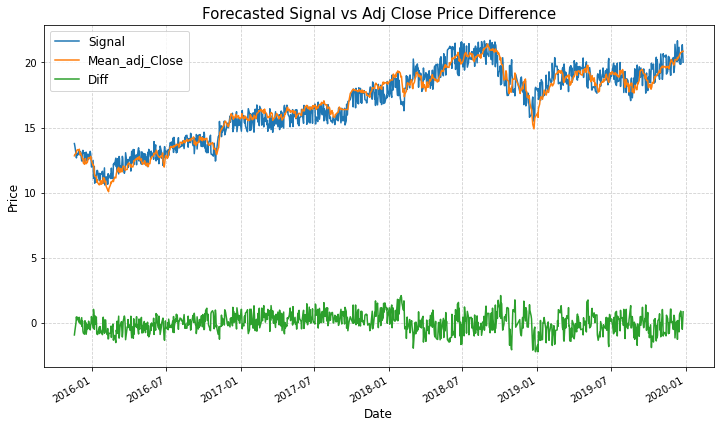

In [14]:
#Normalising the Adj Close to match means with Signal Data
df_clean["Mean_adj_Close"] = ((df_clean["Adj Close"] - df_clean["Adj Close"].mean())/
                              df_clean["Adj Close"].std()) * df_clean["Signal"].std() + df_clean["Signal"].mean()

df_clean["Diff"]= df_clean["Mean_adj_Close"] - df_clean["Signal"]
plot_graph(df_clean,["Signal", "Mean_adj_Close","Diff"], 
           "Forecasted Signal vs Adj Close Price Difference", loc = "upper left")

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
2.3 Checking for Cointegration: Engle-Granger Two-Step Method: </h2><br>


- We already know that the series are correlated and now I am checking if the two time series are cointegrated. If they are then we can be sure of the effectiveness of the signal. 
- To check for cointegration, I am using the Engle-Granger Two-Step Method where I first fit a linear model between the Signal and mean adjusted close price and then check for the stationarity of the residuals. 
- From the below p values of ADF test, we can see that the residuals  stationary so the **Signal and Adjusted close price are cointegrated.**

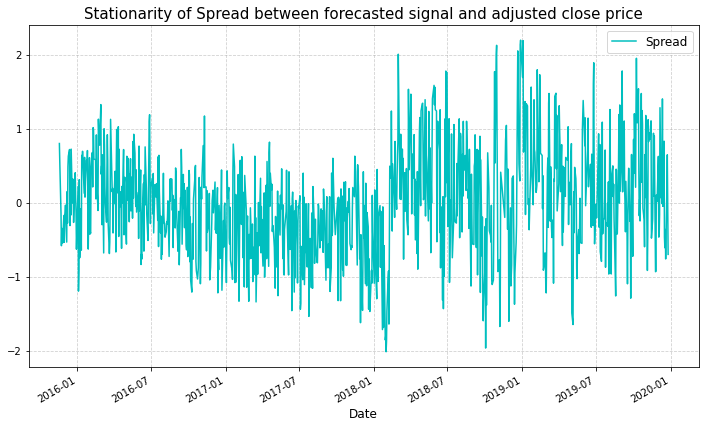

Results of dickey fuller test
Test Statistics               -9.747189e+00
p-value                        8.196138e-17
No. of lags used               3.000000e+00
Number of observations used    1.014000e+03
critical value (1%)           -3.436815e+00
critical value (5%)           -2.864395e+00
critical value (10%)          -2.568290e+00
dtype: float64


In [15]:
#Running a linear regression model
X = np.array(df_clean["Mean_adj_Close"])
Y = np.array(df_clean["Signal"])
X = sm.add_constant(X)
model= sm.OLS(Y, X).fit() 

#Collecting the residuals 
df_clean["residuals"] = model.resid

test_stationarity(df_clean["residuals"])

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
2.4 Analysing Trend and Seasonality </h2><br>
        
        
Signal does a great job in following the trend and seasonality of the ETF price. We can see that the trend and seasonality of the signal is same as the Close price

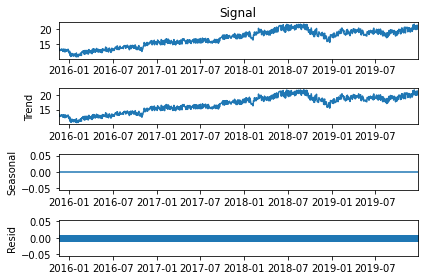

In [16]:
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose
result_signal = seasonal_decompose(df_clean["Signal"], model='additive', period=1)
result_signal.plot()
plt.show()

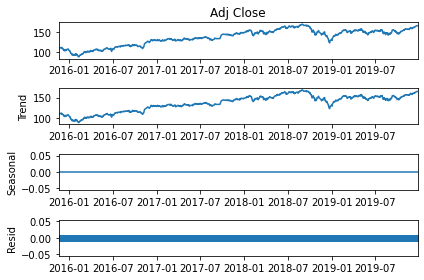

In [17]:
result_actual = seasonal_decompose(df_clean["Adj Close"], model='additive', period=1)
result_actual.plot()
plt.show()

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
2.5 Analysing performance by comparing with benchmark </h2><br>

So far from a statistical point of view, the Signal data seems to be a good predction of the price but to truly analyse its usefullness, we need to see how it performs on a trading strategy on contrast to a benchmark.I am going to follow the below steps for this analysis 
1. Creating a **benchmark ARIMA model prediction** of the ETF Price
3. Compare the **mean absolute error, cumulative returns and max drawdown** of the Signal to the Benchmark to undertsand the effectiveness of the Signal prediction. 






### <span style="color:#2462C0">STEP(1) Building a Benchmark ARIMA model 

Below are the steps that I followed to build a benchmark ARIMA model. 
1. Checked for stationarity of time series. Below **Augmented Dickey Fuller Test** shows that the series is non stationary. 
2. I then performed first differencing to make the data stationary. 
3. Then I analysed the ACF and PACF plots to get the right model parameters. We end up with a **ARIMA(3,1,0) model**
4. Then we make the predictions to get the ARIMA predicted signal. 

**PS :** We could have split the data into train and test sets and then predicted on the test set. But to reduce the complexity of the model, we are just taking the whole data as train data. 

Results of dickey fuller test
Test Statistics                  -1.138723
p-value                           0.699385
No. of lags used                  0.000000
Number of observations used    1017.000000
critical value (1%)              -3.436796
critical value (5%)              -2.864386
critical value (10%)             -2.568285
dtype: float64


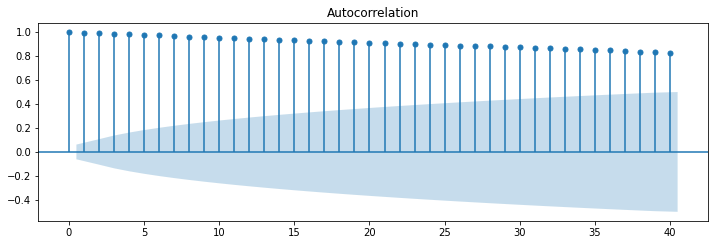

In [18]:
test_stationarity(df_clean["Adj Close"], plot = False)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_clean["Adj Close"],lags=40,ax=ax1)

Results of dickey fuller test
Test Statistics               -8.072896e+00
p-value                        1.532582e-12
No. of lags used               1.700000e+01
Number of observations used    9.980000e+02
critical value (1%)           -3.436919e+00
critical value (5%)           -2.864440e+00
critical value (10%)          -2.568314e+00
dtype: float64


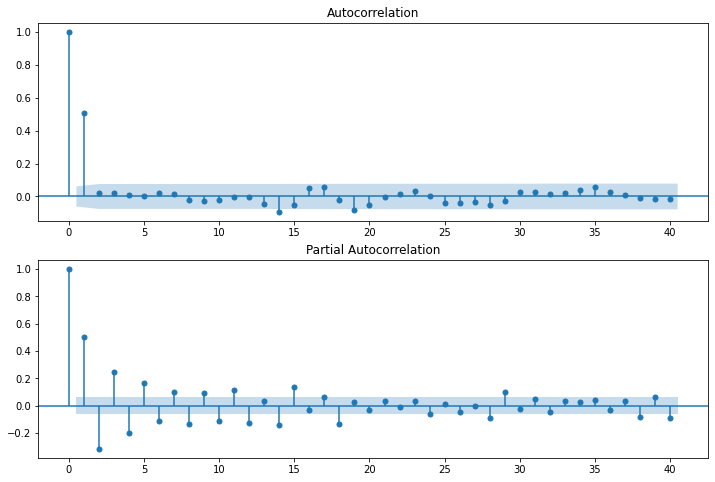

In [19]:
#Making the series stationary. 
df_clean["Close_price"] = df_clean["Adj Close"] - df_clean["Adj Close"].shift(2)
df_clean = df_clean.dropna()

#Checking the stationarity
test_stationarity(df_clean["Close_price"], plot = False)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_clean["Close_price"],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_clean["Close_price"],lags=40,ax=ax2)

In [20]:
# Cross verifying the AR and MA lags 
model_autoARIMA = auto_arima(df_clean["Close_price"], start_p=0, start_q=0,test='adf', max_p=3, max_q=3, 
                      m=1, d=None, seasonal=False, start_P=0, D=0, trace=True,error_action='ignore',  
                      suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4276.878, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3976.303, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3874.281, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3810.905, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.84 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3811.676, Time=0.23 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 2.188 seconds


Results of dickey fuller test


/Users/shreyavontela/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Test Statistics               -8.157999e+00
p-value                        9.306869e-13
No. of lags used               1.800000e+01
Number of observations used    9.970000e+02
critical value (1%)           -3.436926e+00
critical value (5%)           -2.864443e+00
critical value (10%)          -2.568316e+00
dtype: float64


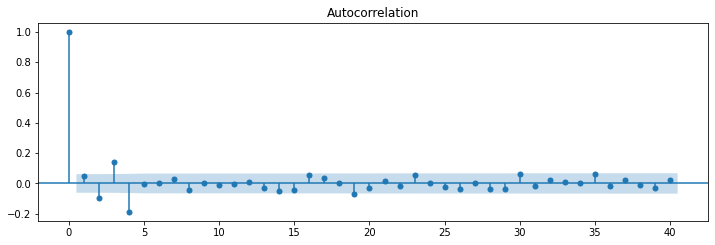

In [21]:
#Building the ARIMA model 
model = ARIMA(df_clean["Close_price"], order=(3,0 , 0))  
fitted = model.fit(disp=-1)  
df_clean["Arima_signal"] = model.predict(df_clean["Close_price"])

#Check stationaity of residuals 
test_stationarity(fitted.resid, plot = False)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(fitted.resid,lags=40,ax=ax1)

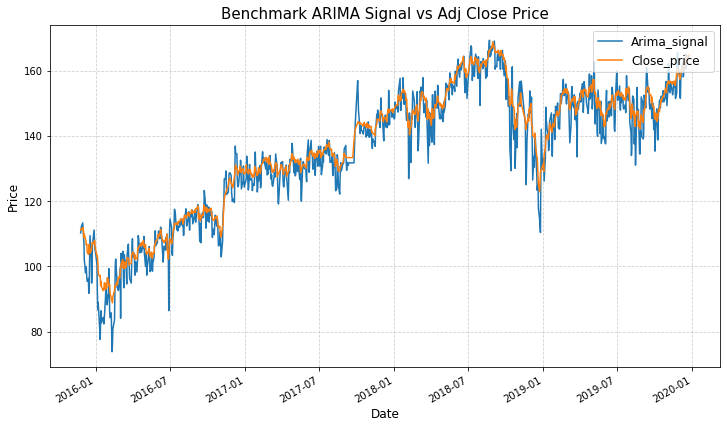

In [22]:
# Readjusting the values to original scale 
df_clean["Arima_signal"] = df_clean["Arima_signal"] + df_clean["Adj Close"].shift(2)
df_clean["Close_price"] = df_clean["Close_price"] + df_clean["Adj Close"].shift(2)
df_clean = df_clean.dropna()

plot_graph(df_clean,["Arima_signal", "Close_price"], 
           "Benchmark ARIMA Signal vs Adj Close Price", loc = "upper right")

<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
2.5.1 Mean Absolute Error and Mean Squared Error </h2><br>

A Predicted model is supposed to reduce the error of predictions. So we are looking at the mean squared and mean absolute error. The **4sight model has better mean alsolute error and mean squared error** compared to the ARIMA model

In [23]:
# Measuring the relative MAE 
mae_4sight = mean_absolute_error(df_clean["Signal"],df_clean["Mean_adj_Close"])
mae_arima = mean_absolute_error(df_clean["Arima_signal"],df_clean["Close_price"])
mse_4sight = mean_squared_error(df_clean["Signal"],df_clean["Mean_adj_Close"])
mse_arima = mean_squared_error(df_clean["Arima_signal"],df_clean["Close_price"])

print(f"\033[1m\033[94mMAE and MSE of 4sight model:\n{25 * '-'}")
print(f"\033[30m{round(mae_4sight,3) , round(mse_4sight,3)}\n")
print(f"\033[1m\033[94mMAE and MSE of ARIMA model:\n{25 * '-'}")
print(f"\033[30m{round(mae_arima,3) , round(mse_arima,3)}")

MAE and MSE of 4sight model:
-------------------------
(0.581, 0.537)

MAE and MSE of ARIMA model:
-------------------------
(3.34, 20.982)


<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
2.5.2 MAX Drawdown prediction </h2><br>

Any model we have should be able to predict the losses better than the gains. Here we look at the max drawdowns predicted by the 4sight model and the arima model and compare it to the actual max drawdown occured in the markets. Here we can see that the **4sight model predicts the exact drawdowns on the exact date but the arima model overestimates the drawdowns and gives a lagged prediction** 

In [24]:
#Measuring the drawdown 
df_clean["4sight_returns"] = df_clean["Signal"].pct_change()
df_clean["arima_returns"] = df_clean["Arima_signal"].pct_change()
df_clean["actual_returns"] = df_clean["Adj Close"].pct_change()

calculate_max_drawdown(df_clean, "4sight_returns", "Max Drawdown predicted by the foresight model",45 )
calculate_max_drawdown(df_clean, "arima_returns", "Max Drawdown predicted by the ARIMA model",45 )
calculate_max_drawdown(df_clean, "actual_returns", "Max Drawdown in the actual data",32 )

Max Drawdown predicted by the foresight model
---------------------------------------------
(-0.287, '12/24/18')

Max Drawdown predicted by the ARIMA model
---------------------------------------------
(-0.349, '02/10/16')

Max Drawdown in the actual data
--------------------------------
(-0.272, '12/24/18')



<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
2.5.3 Cumulative Returns Analysis </h2><br>

- In many scenarios, the signal is used as a metric for a trading strategy where we need **Buy and Sell Indicators**. So we need to check if the signal is giving a proper directional measure. 
- To verify this, I assigned buy siganl for a increased return and sell signal for a decreased return on each day. And based on these buy and sell signals, I am calculated the cumulative returns of 4sight and arima models 
- Below we can see that the **4sight model has a increasing cumulative return trend** compared to the ARIMA model which keeps on decreasing from 2017. 

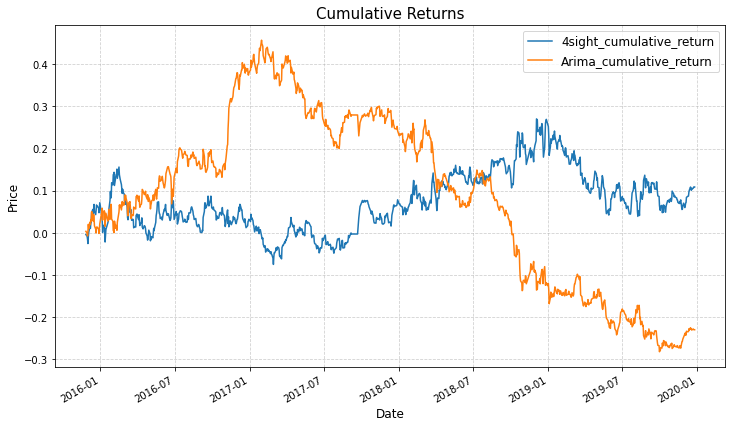

In [25]:
#Calculating cumulative returns over time 
df_clean = cum_returns(df_clean,"4sight_returns","4sight_ind", "cum_4sight","4sight_cumulative_return" )
df_clean = cum_returns(df_clean,"arima_returns","Arima_ind", "cum_arima","Arima_cumulative_return" )
df_clean = cum_returns(df_clean,"actual_returns","Actual_ind", "cum_actual","actual_cumulative_return" )
plot_graph(df_clean,["4sight_cumulative_return", "Arima_cumulative_return"], 
           "Cumulative Returns", loc = "upper right")

<h2 style="font-family: Georgia; font-size:2.5em;color:purple; font-style:bold">
3. Summary for portfolio manager and Next Steps  </h2><br>

## <span style="color:#2462C0"> Analysis Summary 

### <span style="color:#2462C0"> <span style="color:#2462C0"> Data Cleaning Steps
- I started off the analysis by checking if the data is clean. Below are the checks I did: 
    1. Anomalies in the descriptive statistics. 
    2. Missing values or nan values. 
    3. Outliers in the data. 
- There were some outliers present in the Adjusted close price and Forecasted signal. I compared the timings of the outliers on both the series to find that they were not coinciding with any market crashes. So, I concluded that these were **outliers due to model error**. Then, I removed these outliers which were three standard deviations away from the rolling mean. Here I followed a **rolling normalisation methodology to avoid data leakage**. 

### <span style="color:#2462C0"> Model Effectiveness Analysis
- Once I had the clean data, I wanted to check if the model was accurate. Below are the steps I followed to check the model accuracy. 
    1. **Correlation Analysis :** The Signal and Price have a high correlation of 0.96
    2. **Cointegration Analysis :** The Signal and Price are cointegrated 
    3. **Normalisation Analysis :** The Signal and Price were on different scales. So I normalised the price of the ETF to match the mean and variance of the signal. (This step can be done the other way too where we transform the signal to have the mean of the ETF price). The resulting values showed that the signal was accurately tracking the trend and movements in price. 
    4. **Trend and Seasonality Analysis :** I decomposed the time series to get the trend and seasonality components and both Signal and Price had similar trend and seasonality 
    5. **Comparision with Benchmark :** I created a benchmark ARIMA signal and compared the performance of Signal with the ARIMA forecast. I checked the below aspects: 
        - Mean Absolute Error 
        - Mean Squared Error 
        - Max Drawdown 
        - Cumulative returns (on a simple daily returns based trading strategy)
    
    After analysing all of the above metrics, I feel that the **4sight model has a good predictive power** in general and in comparision with the ARIMA benchmark prediction. 

## <span style="color:#2462C0"> Conclusion 
- Overall, the product used to predict Signal is doing a **great job in predicting the overall trend, seasonality and directional movement of the ETF**. Although there are some outliers, they can be easily handled. 
- I have looked at several metrics like MAE,MSE and max drawdown to find the effectiveness of Signal but to know the true effectiveness of Signal, we need to use it in an end to end trading strategy and calculate the Sharpe ratio and returns of this trading strategy. 


## <span style="color:#2462C0"> Recommendations for next steps 
- As we have the predicted Signal value, as a next step we can build different trading strategies (Long only, Long Short, Long term trading, Day trading etc) and see the performance of the Signal on several strategies. 
- To test this performance, we can use metrics like **rolling returns, Sharpe Ratio or max drawdown**. 
- We can do different **scenario analysis, stress testing and back testing** for this 4sight model to understand the robustness of the model. 